In [7]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from prg import prg
np.random.seed(7)

from keras.regularizers import l2
from keras.models import Sequential, load_model
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling2D, MaxPooling1D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM
from keras.optimizers import RMSprop
from keras.initializers import Zeros
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ProgbarLogger
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import to_categorical
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, roc_auc_score, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler

from retreive_data import unpack_gzip

import keras.backend as K

#sess = tf.Session()

In [ ]:
plt.rcParams["figure.figsize"] = (20,5)
file_name = "../data/ATAC_STARRdata/output.txt"
data_f = open(file_name).readlines()

sharpr_score = sorted([float(l.split("\t")[1]) for l in data_f])
lengths = sorted([int(l.split("\t")[5]) for l in data_f])

#Normal distribution of SHARPR scores and region lengths
# pdf = stats.norm.pdf(sharpr_score, np.mean(sharpr_score), np.std(sharpr_score))
# plt.plot(sharpr_score, pdf, '-o')
plt.hist(np.log(sharpr_score), bins=100)
plt.title("Distribution of RNA/DNA content");

average number of bases per region:  0


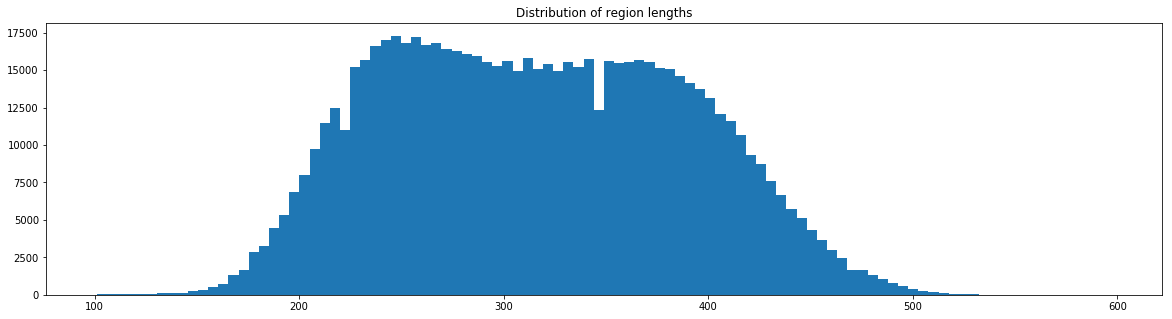

In [3]:
import os
total_bases = os.popen("awk '{sum+=$3} END {print sum}' " + file_name).read()

print "average number of bases per region: ", int(total_bases)/len(data_f)
plt.hist(lengths, bins=100)
plt.title("Distribution of region lengths");

currently running zero-padding to truncate at 500bp


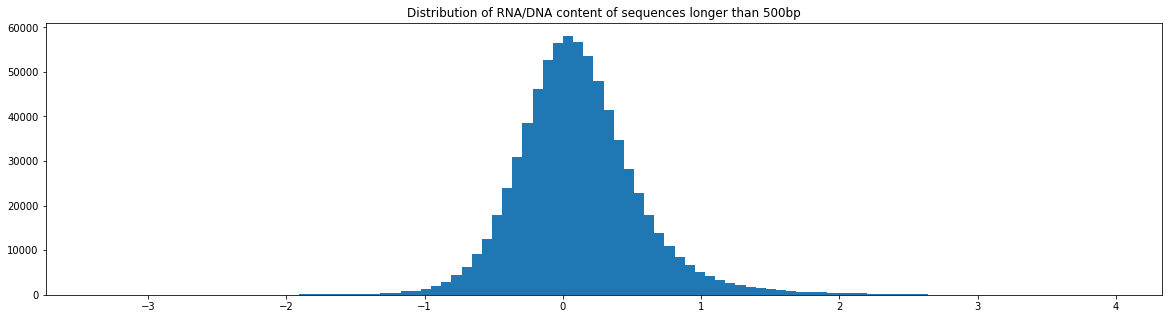

In [4]:
print "currently running zero-padding to truncate at 500bp"
grt_500 = []
for l in data_f:
    if l.split("\t")[2] > 500:
        grt_500.append(float(l.split("\t")[1]))
plt.hist(np.log(grt_500), bins=100)
plt.title("Distribution of RNA/DNA content of sequences longer than 500bp");

In [8]:
print "unpacking data"
x, y = (4, 500)

batch_size = 1000
#num_batches = n/batch_size

#generator for data
def generator():
    for i in ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]: #, "13", "14", "15", "16", "17", "18", "19", "20", "21"]:
        print "using chromosome ", i
        try:
            x_data, y_data = unpack_gzip("chr" + i + ".txt.gz")
        except:
            print "couldn't unpack"
#         x_data.extend(list(x))
#         y_data.extend(list(y))

        n = len(x_data)
        try:
            assert (n == len(y_data))
        except AssertionError:
            print str(n) + " and " + str(len(y_data)) + " do not match"

        #Shuffling
        d = zip(x_data, y_data)
        np.random.shuffle(d)
        x_data, y_data = zip(*d)
        x_data, y_data = np.asarray(x_data), np.asarray(y_data)

        #Taking log of RNA/DNA
        y_data=np.log(y_data)

        #4/6 as training data, 1/6 as test, 1/6 as validation                                                                                                                                  
#        train = (x_data[2*n/6:], y_data[2*n/6:])                                                                  
#         test = (x_data[:n/6], y_data[:n/6])
#         val = (x_data[n/6:2*n/6], y_data[n/6:2*n/6])

        #reshape for conv layer
        train_data = x_data.reshape(x_data.shape[0], x, y, 1) 
#        train_data = train[0].reshape(train[0].shape[0], x, y, 1)
#         test_data = test[0].reshape(test[0].shape[0], x, y, 1)
#         val_data = val[0].reshape(val[0].shape[0], x, y, 1)
        print "training shape: " + str(train_data.shape)

        #Generating sample weights
        s_weights = np.abs(stats.zscore(y_data))
        
        yield (train_data, y_data, s_weights)

unpacking data


In [9]:
classif = True

file_suffix = ""
if classif:
    file_suffix = "_binary1.txt.gz"
else:
    file_suffix = "_better.txt.gz"

#Non-batch training
x_data = list()
y_data = list()

for i in ["3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22"]: #chr 2 and 14 has problems sigh
    print "using chromosome ", i
    x, y = unpack_gzip("chr" + i + file_suffix)
    x_data.extend(list(x))
    y_data.extend(list(y))

x, y = (4, 500)
n = len(x_data)
try:
    assert (n == len(y_data))
except AssertionError:
    print str(n) + " and " + str(len(y_data)) + " do not match"

#Shuffling
d = zip(x_data, y_data)
np.random.shuffle(d)
x_data, y_data = zip(*d)
x_data, y_data = np.asarray(x_data), np.asarray(y_data)

#Taking log of RNA/DNA
if not classif:
    y_data=np.log(y_data)
else:
    y_data=np.asarray([max(int(i), 0) for i in y_data])

#4/6 as training data, 1/6 as test, 1/6 as validation     
train = (x_data, y_data)
# train = (x_data[2*n/6:], y_data[2*n/6:])                                                                  
# test = (x_data[:n/6], y_data[:n/6])
# val = (x_data[n/6:2*n/6], y_data[n/6:2*n/6])

#reshape for conv layer
train_data = train[0].reshape(train[0].shape[0], x, y, 1)
# test_data = test[0].reshape(test[0].shape[0], x, y, 1)
# val_data = val[0].reshape(val[0].shape[0], x, y, 1)
print "training shape: " + str(train_data.shape)

#Generating sample weights
if not classif:
    s_weights = np.abs(stats.zscore(train[1]))

#yield (train_data, y_data, s_weights)

using chromosome  3
using chromosome  4
using chromosome  5
using chromosome  6
using chromosome  7
using chromosome  8
using chromosome  9
using chromosome  10
using chromosome  11
using chromosome  12
using chromosome  13
using chromosome  14
using chromosome  15
using chromosome  16
using chromosome  17
using chromosome  18
using chromosome  19
using chromosome  20
using chromosome  21
using chromosome  22
training shape: (154249, 4, 500, 1)


In [10]:
#validation and test

val = unpack_gzip("chr2" + file_suffix)
test = unpack_gzip("chr1" +  file_suffix) 

test_data = test[0].reshape(test[0].shape[0], x, y, 1)
val_data = val[0].reshape(val[0].shape[0], x, y, 1)

if classif:
    val = (val[0], np.asarray([max(int(i), 0) for i in val[1]]))
    test = (test[0], np.asarray([max(int(i), 0) for i in test[1]]))

In [ ]:
print "running hyperoptimization"
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# space = {#'filters': hp.uniform('filters', 40, 400),
#         'kernel_size': hp.choice('kernel_size', np.asarray([7, 20, 33, 46])),
#         'fc_nodes': hp.choice('fc_nodes', np.arange(4, 80, dtype=int)),
# #        'fc_nodes': hp.uniform('fc_nodes', 4, 60),
#         'dropout': hp.uniform('dropout', .05, .5),
#         'l2_var': hp.uniform('l2_var', .0001, .1)}

def f_nn(params):
    import sys
    
    print "Params: ", params
    
    model = Sequential()
    model.add(Conv2D(filters=128,
                      input_shape=(x, y, 1), #input dim: 4 x 500 (x, y, 1) 
                      kernel_size= (4, int(params['kernel_size'])), #26, #(4, 40), 
                      padding="valid",
                      activation="relu",
                      strides=(4, 1)
    ))
    model.add(MaxPooling2D(pool_size= (1, 13), padding="valid"))                   
    model.add(Flatten())
    model.add(Dense(params['fc_nodes'], activation="relu", kernel_initializer="normal", kernel_regularizer=l2(params['l2_var'])))
    model.add(Dropout(params['dropout']))
    model.add(Dense(1, kernel_initializer="normal"))                                

    print "compiling"

    model.compile(loss='mse', optimizer='adam')
    
    earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    model.fit(train_data, train[1],
          batch_size=1000,
          epochs=10,
          sample_weight=s_weights,
          validation_data=(val_data, val[1]),
          shuffle='batch',
          verbose=2,
          callbacks=[earlystopper])
    
    from sklearn.metrics import mean_squared_error
    acc = mean_squared_error(model.predict(test_data), test[1])
    sys.stdout.flush() 
    return {'loss': acc, 'status': STATUS_OK}


space = {'filters': hp.choice('filters', np.arange(50, 150)),
        'kernel_size': hp.choice('kernel_size', np.arange(16, 24)),
        'fc_nodes': hp.choice('fc_nodes', np.arange(4, 14)),
        'dropout': hp.uniform('dropout', .1, .4),
        'l2_var': hp.uniform('l2_var', .0001, .01)}

all_params = []

def c_nn(params):
    import sys
    print "Params:", params
    
    model = Sequential()
    conv_layer = (Conv2D(filters=params['filters'], #num_motifs,
                      input_shape=(x, y, 1), #input dim: 4 x 500 (x, y, 1) 
                      kernel_size= (4, params['kernel_size']),#length_motif), #26, #(4, 40), 
                      kernel_initializer='normal',
                      use_bias=False,
                      padding="valid",
                      activation="relu",
                      strides=(4, 1)
    )) 
    model.add(conv_layer)
    model.add(MaxPooling2D(pool_size= (1, 13), padding="valid"))                   
    model.add(Flatten())
    model.add(Dense(params["fc_nodes"], activation="relu", kernel_initializer="normal", kernel_regularizer=l2(params['l2_var'])))
    model.add(Dropout(params['dropout']))
    model.add(Dense(1, kernel_initializer="normal", activation="sigmoid")) 
    
    print "compiling"

    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

    model.fit(train_data, train[1],
              batch_size=batch_size,
              epochs=20,
              validation_data=(val_data, val[1]),
              shuffle='batch',
              verbose=2,
              callbacks=[earlystopper])

    from sklearn.metrics import roc_auc_score
    acc = roc_auc_score(test[1], model.predict(test_data))
    print "auroc:", acc
    all_params.append((params, acc, model)) #storing all 100 evaluations to look at later
    sys.stdout.flush() 
    return {'loss': -acc, 'status': STATUS_OK}
    return model

trials = Trials()
print "starting hyperopt"
best = fmin(c_nn, space, algo=tpe.suggest, max_evals=100, trials=trials)

# with open('output.txt', 'wb') as f:
#     f.write(best)

running hyperoptimization
starting hyperopt
Params: {'dropout': 0.20718693209377115, 'fc_nodes': 6, 'filters': 108, 'kernel_size': 22, 'l2_var': 0.0038931468177480703}
compiling
Train on 154249 samples, validate on 18481 samples
Epoch 1/20
36s - loss: 0.7147 - val_loss: 0.6598
Epoch 2/20
35s - loss: 0.6523 - val_loss: 0.6577
Epoch 3/20
34s - loss: 0.6435 - val_loss: 0.6320
Epoch 4/20
35s - loss: 0.6256 - val_loss: 0.6338
Epoch 5/20
35s - loss: 0.6109 - val_loss: 0.6413
Epoch 6/20
35s - loss: 0.5996 - val_loss: 0.5981
Epoch 7/20
35s - loss: 0.5939 - val_loss: 0.6136
Epoch 8/20
35s - loss: 0.5881 - val_loss: 0.5992
Epoch 9/20
35s - loss: 0.5815 - val_loss: 0.6048
Epoch 10/20
34s - loss: 0.5766 - val_loss: 0.5788
Epoch 11/20
35s - loss: 0.5725 - val_loss: 0.5838
Epoch 12/20
35s - loss: 0.5674 - val_loss: 0.5838
Epoch 13/20
35s - loss: 0.5640 - val_loss: 0.5885
Epoch 14/20
35s - loss: 0.5627 - val_loss: 0.6248
Epoch 00013: early stopping
auroc: 0.786326826389
Params: {'dropout': 0.13987781

In [25]:
#best results of hyperopt
print best
for p in all_params:
    if p[1] > .808:
        print p[1], p[0]

hyp_res = np.array(all_params)
np.save("hyperoptstd12_res.npy", hyp_res)

{'dropout': 0.20752981222217376, 'fc_nodes': 3, 'kernel_size': 2, 'filters': 97, 'l2_var': 0.006683856551781361}
0.808766161456 {'dropout': 0.1369782275377313, 'fc_nodes': 10, 'filters': 138, 'kernel_size': 17, 'l2_var': 0.007115869513663622}
0.811478338391 {'dropout': 0.20752981222217376, 'fc_nodes': 7, 'filters': 147, 'kernel_size': 18, 'l2_var': 0.006683856551781361}
0.810068627185 {'dropout': 0.15742715075721114, 'fc_nodes': 7, 'filters': 116, 'kernel_size': 18, 'l2_var': 0.008767878221260116}
0.80904790817 {'dropout': 0.2262975097216844, 'fc_nodes': 7, 'filters': 123, 'kernel_size': 18, 'l2_var': 0.008155385507278677}
0.809381570349 {'dropout': 0.23129257723283647, 'fc_nodes': 13, 'filters': 84, 'kernel_size': 18, 'l2_var': 0.002017541066537441}
0.809821018736 {'dropout': 0.28885165427329706, 'fc_nodes': 7, 'filters': 88, 'kernel_size': 18, 'l2_var': 0.0023716906667473623}
0.808912735307 {'dropout': 0.3543031056696424, 'fc_nodes': 7, 'filters': 124, 'kernel_size': 18, 'l2_var': 0.

PicklingError: Can't pickle <type 'module'>: attribute lookup __builtin__.module failed

In [1]:
#custom error
# data_mean = np.mean(y_data).astype(np.float32)
# data_variance = np.var(y_data).astype(np.float32)
# dist = tf.contrib.distributions.Normal(loc=data_mean, scale=data_variance)

def z_score_error(y_true, y_pred):
    return tf.abs(dist.cdf(y_true) - dist.cdf(y_pred)) #should this be abs or mse?

#custom kernel weights
num_motifs = 519
length_motif = 26 #64
# with open("jasper_processed.txt", "r") as ms:
#     motifs = [l.split() for l in ms]
# motifs = np.array(motifs)
# motifs = motifs.reshape(1, num_motifs, 4, length_motif, 1)
# motifs = motifs.transpose((0, 2, 3, 4, 1))

# count = -1
# def jasper_motifs(shape, dtype=None):
#     global count
#     count += 1
#     return motifs[count]

def reg_model():
    print "building model"
    model = Sequential()
    conv_layer = (Conv2D(filters=128, #num_motifs,
                      input_shape=(x, y, 1), #input dim: 4 x 500 (x, y, 1) 
                      kernel_size= (4, 26), #26, #(4, 40), 
                      kernel_initializer='normal',
                      use_bias=False,
                      padding="valid",
                      activation="relu",
                      strides=(4, 1)
    ))
    model.add(conv_layer)
    model.add(MaxPooling2D(pool_size= (1, 13), padding="valid"))                   
    model.add(Flatten())
    model.add(Dense(47, activation="relu", kernel_initializer="normal", kernel_regularizer=l2(0.05881)))
    model.add(Dropout(.311))
    model.add(Dense(1, kernel_initializer="normal"))       
    
    #setting weights
#     conv_weights = conv_layer.get_weights()
#     conv_weights = motifs
#     conv_layer.set_weights(conv_weights)

    print "compiling"

    model.compile(loss='mse', optimizer='adam')

    print model.summary()
    return model

In [24]:
def linear_model():
    print "building model"

    model = Sequential()
    model.add(Dense(200, kernel_initializer="normal", input_shape=(x, y, 1), activation="relu")) 
    model.add(Dropout(.4)) 
    model.add(Flatten())
    model.add(Dense(25, activation="softmax", kernel_initializer="normal"))
    model.add(Dense(1, kernel_initializer="normal"))     

    print "compiling"

    model.compile(loss='mse', optimizer='rmsprop')

    print model.summary()
    return model

In [27]:
def lstm_model():
    print "building model"
    
    model = Sequential()
    model.add(LSTM(200, input_shape=(x, y, 1), return_sequences=True))
    model.add(Dense(1))
    
    print "compiling"
    model.compile(loss='mse', optimizer='adam')
    
    print model.summary()
    return model

In [8]:
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
tensorboard = TensorBoard(log_dir='./logs',
                                                   histogram_freq=0,
                                                   write_graph=True,
                                                   write_grads=False,
                                                   write_images=True,
                                                   embeddings_freq=0,
                                                   embeddings_layer_names=None,
                                                   embeddings_metadata=None)
checkpt = ModelCheckpoint(filepath="best_model.hdf5", monitor='val_loss', verbose=1, save_best_only=True)
#progbar = ProgbarLogger(count_mode='samples')

#batch = generator()

modela = reg_model()
modela.fit(train_data, train[1],
          batch_size=batch_size,
          #steps_per_epoch=50,
          epochs=50,
          validation_data=(val_data, val[1]),
          shuffle='batch',
          verbose=2,
          sample_weight=s_weights,
          #interval=.1,
          callbacks=[earlystopper, tensorboard, checkpt])

print "done"

building model
compiling
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 475, 128)       13312     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 36, 128)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 47)                216623    
_________________________________________________________________
dropout_1 (Dropout)          (None, 47)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 48        
Total params: 229,983
Trainable params: 229,983
Non-trainable params: 0
_____________________________________________

KeyboardInterrupt: 

In [16]:
#Start here with a trained model
modela = load_model("best_model_std11.hdf5")
results = modela.predict(test_data, batch_size=1000, verbose=2)
print results

[[ 0.86785948]
 [ 0.70306998]
 [ 0.88009596]
 ..., 
 [ 0.47133338]
 [ 0.5905757 ]
 [ 0.26635888]]


In [56]:
print "test error: ", mean_squared_error(test[1], results)
print "r, p: ", stats.pearsonr(results.flatten(), test[1])
print "r^2: ", r2_score(test[1], results)

test error:  0.11681886248
r, p:  (0.27608480709491484, 0.0)
r^2:  0.0555645646088


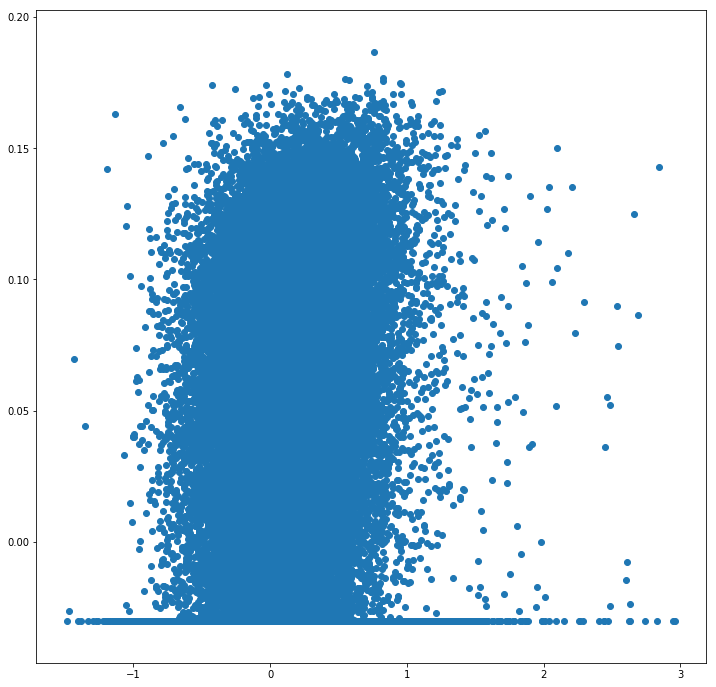

In [57]:
#is it even normal
plt.rcParams["figure.figsize"] = (12,12)
plt.scatter(test[1], results); #y-axis: actual score distribution...

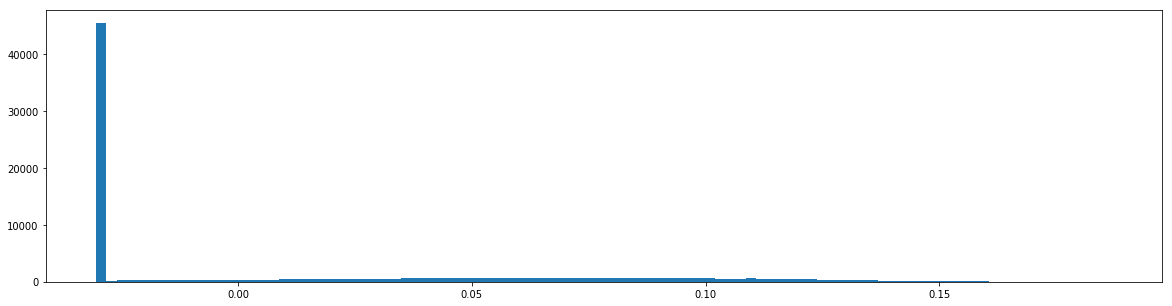

In [58]:
plt.rcParams["figure.figsize"] = (20,5)
plt.hist(results, bins=100);

In [ ]:
#Troubleshooting
weights, biases = model.layers[0].get_weights()
print weights

In [17]:
print "roc score:", roc_auc_score(test[1], results)
precision, recall = precision_recall_curve(test[1], results)[:2]
print "auprc:", auc(recall, precision)
# prg_curve = prg.create_prg_curve(test[1], results)
# auprg = prg.calc_auprg(prg_curve)
# print(auprg)


roc score: 0.798432460603
auprc: 0.793502491927


In [ ]:
data_res = np.load(std1res.npy)

y_real = []
y_pred = []
for i in range(1, 23):
    y_real = y_real + list(chrm_res_dict["chr" + str(i)][0])
    y_pred = y_pred + list(chrm_res_dict["chr" + str(i)][1])
print "roc score:", roc_auc_score(y_real, y_pred)
precision, recall = precision_recall_curve(y_real, y_pred)[:2]
print "auprc:", auc(recall, precision)

In [13]:
gc.collect()

IndexError: list index out of range

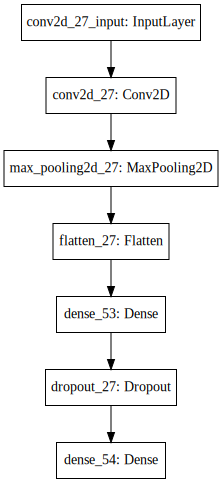